In [1]:
import networkx as nx
import pandas as pd
import torch_geometric
from torch_geometric.utils import from_networkx
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2  

In [2]:
NYU_PATH = "C:/Users/deshu/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data"
nyu_train_csv = os.path.join(NYU_PATH, "nyu2_train.csv")
nyu_test_csv = os.path.join(NYU_PATH, "nyu2_test.csv")

if os.path.exists(nyu_train_csv):
    nyu_train_df = pd.read_csv(nyu_train_csv)
    print("NYU Train CSV:", nyu_train_df.shape)
    display(nyu_train_df.head())
else:
    print("NYU Train CSV not found!")

NYU Train CSV: (50687, 2)


,data/nyu2_train/living_room_0038_out/37.jpg,data/nyu2_train/living_room_0038_out/37.png
0,data/nyu2_train/living_room_0038_out/115.jpg,data/nyu2_train/living_room_0038_out/115.png
1,data/nyu2_train/living_room_0038_out/6.jpg,data/nyu2_train/living_room_0038_out/6.png
2,data/nyu2_train/living_room_0038_out/49.jpg,data/nyu2_train/living_room_0038_out/49.png
3,data/nyu2_train/living_room_0038_out/152.jpg,data/nyu2_train/living_room_0038_out/152.png
4,data/nyu2_train/living_room_0038_out/142.jpg,data/nyu2_train/living_room_0038_out/142.png


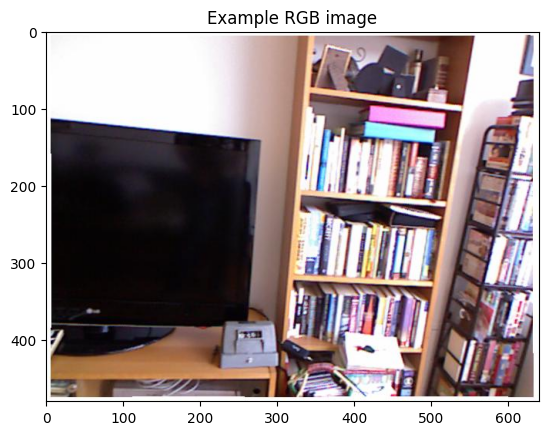

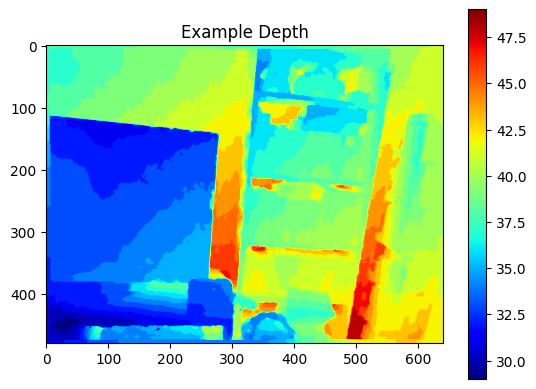

In [3]:
sample_image_path = "C:/Users/deshu/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data/nyu2_train/living_room_0020_out/208.jpg"
sample_depth_path = "C:/Users/deshu/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data/nyu2_train/living_room_0020_out/208.png"

if os.path.exists(sample_image_path):
    img = cv2.imread(sample_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  #  BGR -> RGB for plt
    plt.imshow(img)
    plt.title("Example RGB image")
    plt.show()
else:
    print("Sample RGB image not found at:", sample_image_path)

if os.path.exists(sample_depth_path):
    depth = cv2.imread(sample_depth_path, cv2.IMREAD_UNCHANGED)
    plt.imshow(depth, cmap='jet')
    plt.title("Example Depth")
    plt.colorbar()
    plt.show()
else:
    print("Sample Depth image not found at:", sample_depth_path)

In [4]:
from torch.utils.data import DataLoader, Dataset
CSV_PATH_TRAIN = "C:/Users/deshu/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data/nyu2_train.csv"
CSV_PATH_TEST = "C:/Users/deshu/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data/nyu2_test.csv"
ROOT_DIR = "C:/Users/deshu/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/"

nyu_train_df = pd.read_csv(CSV_PATH_TRAIN,   
                           sep=',',
                           header=None, 
                           names=["rgb", "depth"])

nyu_test_df = pd.read_csv(CSV_PATH_TEST, 
                          sep=',', 
                          header=None,
                          names=["rgb", "depth"])

In [5]:
class DepthDataset(Dataset):
    def __init__(self, dataframe, root_dir, img_height=240, img_width=320, transform=None):
        """
        :param dataframe: pd.DataFrame [rgb, depth]
        :param root_dir: folder dataframe
        :param img_height, img_width: resize to
        :param transform: augmentation
        """
        self.df = dataframe.reset_index(drop=True)
        self.root_dir = root_dir
        self.img_height = img_height
        self.img_width = img_width
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        rgb_path = os.path.join(self.root_dir, row["rgb"])   
        #print(rgb_path, os.path.exists(rgb_path))
        depth_path = os.path.join(self.root_dir, row["depth"])
        #print(depth_path, os.path.exists(depth_path))
        

        # (BGR -> RGB)
        rgb_img = cv2.imread(rgb_path)
        if rgb_img is None:
            print("Warning: Failed to load image:", rgb_path)
        rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
        rgb_img = cv2.resize(rgb_img, (self.img_width, self.img_height))

        # Depth 
        depth_img = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
        depth_img = cv2.resize(depth_img, (self.img_width, self.img_height))

        # to float32
        rgb_img = rgb_img.astype(np.float32) / 255.0
        depth_img = depth_img.astype(np.float32)

        # to tensor PyTorch: (C,H,W)
        rgb_tensor = torch.from_numpy(np.transpose(rgb_img, (2,0,1)))   # (3, H, W)
        depth_tensor = torch.from_numpy(depth_img).unsqueeze(0)         # (1, H, W)

        return rgb_tensor, depth_tensor

In [6]:
IMG_HEIGHT = 480
IMG_WIDTH = 640
BATCH_SIZE = 4

train_dataset = DepthDataset(nyu_train_df, ROOT_DIR, IMG_HEIGHT, IMG_WIDTH)
test_dataset = DepthDataset(nyu_test_df, ROOT_DIR, IMG_HEIGHT, IMG_WIDTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

Train samples: 50688
Test samples: 654


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F  
from torchvision.models import resnet18
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
import numpy as np
import networkx as nx
import torch.optim as optim


def build_grid_edge_index(H, W, connectivity=4):
    nodes = H * W
    indices = np.arange(nodes).reshape(H, W)
    edge_list = []
    if connectivity == 4:
        offsets = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    elif connectivity == 8:
        offsets = [(-1, 0), (1, 0), (0, -1), (0, 1),
                   (-1, -1), (-1, 1), (1, -1), (1, 1)]
    else:
        raise ValueError("connectivity must be 4 or 8")
    for i in range(H):
        for j in range(W):
            current = indices[i, j]
            for di, dj in offsets:
                ni, nj = i + di, j + dj
                if 0 <= ni < H and 0 <= nj < W:
                    neighbor = indices[ni, nj]
                    edge_list.append([current, neighbor])
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    return edge_index


class CNN2GNN_FlyPrior(nn.Module):
    def __init__(self, cnn_out_channels=64, gnn_hidden_dim=64, num_gnn_layers=2, fly_embed_dim=64):
        super(CNN2GNN_FlyPrior, self).__init__()
        # 1. CNN Backbone: Use a pretrained ResNet-18.
        backbone = resnet18(pretrained=True)
        self.cnn_backbone = nn.Sequential(*list(backbone.children())[:-2])
        # Reduce channels from 512 to cnn_out_channels.
        self.cnn_reducer = nn.Conv2d(512, cnn_out_channels, kernel_size=1)
        
        # 2. GNN Layers: Stack of GCNConv layers.
        self.gnn_layers = nn.ModuleList()
        in_channels = cnn_out_channels
        for _ in range(num_gnn_layers):
            self.gnn_layers.append(GCNConv(in_channels, gnn_hidden_dim))
            in_channels = gnn_hidden_dim
        
        # 3. FlyBrain Prior: A learnable embedding per node.
        # Assume fixed grid size after CNN (e.g., if feature map is 20x30, then num_nodes=600).
        self.num_nodes = 600  # Adjust this value to match your CNN feature map size.
        self.fly_prior = nn.Embedding(self.num_nodes, fly_embed_dim)
        
        # 4. Fusion: Fuse GNN output with the fly prior.
        self.fusion = nn.Linear(gnn_hidden_dim + fly_embed_dim, gnn_hidden_dim)
        
        # 5. Decoder: Upsample fused grid features back to a dense depth map.
        self.decoder = nn.Sequential(
            nn.Conv2d(gnn_hidden_dim, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1)  # Output single-channel depth map.
        )
    
    def forward(self, x):
        """
        x: Input RGB image tensor of shape [B, 3, H_img, W_img]
        Returns:
            Depth map tensor of shape [B, 1, H_img, W_img]
        """
        B, C, H_img, W_img = x.shape
        # 1. Extract CNN features.
        feat_map = self.cnn_backbone(x)   # [B, 512, H_feat, W_feat]
        feat_map = self.cnn_reducer(feat_map)  # [B, cnn_out_channels, H_feat, W_feat]
        B, C_feat, H_feat, W_feat = feat_map.shape  # Use C_feat for channel dimension.
        num_nodes = H_feat * W_feat  # Expected to match self.num_nodes (or adjust accordingly).
        
        # Build grid graph edge_index (same for all images).
        edge_index = build_grid_edge_index(H_feat, W_feat, connectivity=4).to(x.device)
        
        outputs = []
        for b in range(B):
            # Reshape CNN feature map into node features: [num_nodes, C_feat]
            node_feats = feat_map[b].view(C_feat, -1).t()  # [num_nodes, C_feat]
            
            # 2. Pass node features through GNN layers.
            for conv in self.gnn_layers:
                node_feats = conv(node_feats, edge_index)
                node_feats = F.relu(node_feats)
            
            # 3. Get fly brain prior embedding.
            if num_nodes != self.num_nodes:
                fly_embed = self.fly_prior.weight[:num_nodes]
            else:
                fly_embed = self.fly_prior.weight  # [num_nodes, fly_embed_dim]
            
            # 4. Fusion: Concatenate and apply linear fusion.
            fused = torch.cat([node_feats, fly_embed], dim=1)  # [num_nodes, gnn_hidden_dim + fly_embed_dim]
            fused = self.fusion(fused)  # [num_nodes, gnn_hidden_dim]
            
            # 5. Reshape fused node features back to grid: [1, gnn_hidden_dim, H_feat, W_feat]
            fused_grid = fused.t().view(1, -1, H_feat, W_feat)
            
            # 6. Decode fused features into a depth map.
            depth_map = self.decoder(fused_grid)  # [1, 1, H_out, W_out]
            # Upsample the predicted depth map to match the original input resolution.
            depth_map = F.interpolate(depth_map, size=(H_img, W_img), mode='bilinear', align_corners=True)
            outputs.append(depth_map)
        
        outputs = torch.cat(outputs, dim=0)  
        return outputs



IMG_HEIGHT = 480
IMG_WIDTH = 640
BATCH_SIZE = 4

train_dataset = DepthDataset(nyu_train_df, ROOT_DIR, img_height=IMG_HEIGHT, img_width=IMG_WIDTH)
test_dataset = DepthDataset(nyu_test_df, ROOT_DIR, img_height=IMG_HEIGHT, img_width=IMG_WIDTH)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN2GNN_FlyPrior(cnn_out_channels=64, gnn_hidden_dim=64, num_gnn_layers=2, fly_embed_dim=64).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()  

num_epochs = 10

# model.train()
# for epoch in range(num_epochs):
#     epoch_loss = 0.0
#     for rgb_tensor, depth_tensor in train_loader:
#         rgb_tensor = rgb_tensor.to(device)           
#         depth_tensor = depth_tensor.to(device).float() 
        
#         optimizer.zero_grad()
#         pred_depth = model(rgb_tensor)                 
#         loss = loss_fn(pred_depth, depth_tensor)
#         loss.backward()
#         optimizer.step()
        
#         epoch_loss += loss.item() * rgb_tensor.size(0)
    
#     avg_loss = epoch_loss / len(train_dataset)
#     print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

# print("Training complete!")

Train samples: 50688
Test samples: 654


C:\Users\deshu\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\deshu\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# save_path = "cnn2gnn_flyprior.pth"
# torch.save({
#     'epoch': num_epochs,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'loss': avg_loss,
# }, save_path)
# print("Model saved at", save_path)

In [9]:
# model = CNN2GNN_FlyPrior(cnn_out_channels=64, gnn_hidden_dim=64, num_gnn_layers=2, fly_embed_dim=64)
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

# checkpoint = torch.load("cnn2gnn_flyprior.pth", map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# start_epoch = checkpoint['epoch']
# last_loss = checkpoint['loss']

# model.to(device)
# model.eval()  
# print("Model loaded and ready for inference!")

In [10]:
import matplotlib.pyplot as plt

def test_and_visualize(model, data_loader, device):
    model.eval()  
    with torch.no_grad():
        for rgb_tensor, depth_tensor in data_loader:
            rgb_tensor = rgb_tensor.to(device)
            depth_tensor = depth_tensor.to(device).float()
            
            pred_depth = model(rgb_tensor)  # Shape: [B, 1, H, W]
            
            pred_depth = pred_depth.cpu().numpy()
            depth_tensor = depth_tensor.cpu().numpy()
            rgb_tensor = rgb_tensor.cpu().numpy()
            
            idx = 0
            rgb_img = np.transpose(rgb_tensor[idx], (1, 2, 0))  # Convert to H x W x C.
            gt_depth = depth_tensor[idx, 0, :, :]
            pred_heatmap = pred_depth[idx, 0, :, :]

            plt.figure(figsize=(18, 6))
            
            plt.subplot(1, 3, 1)
            plt.imshow(rgb_img)
            plt.title("RGB Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(gt_depth, cmap='viridis')
            plt.title("Ground Truth Depth")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(pred_heatmap, cmap='viridis')
            plt.title("Predicted Depth Heat Map")
            plt.axis("off")

            plt.show()
            break

In [11]:
IMG_HEIGHT = 480
IMG_WIDTH = 640
BATCH_SIZE = 4

train_dataset = DepthDataset(nyu_train_df, ROOT_DIR, img_height=IMG_HEIGHT, img_width=IMG_WIDTH)
test_dataset = DepthDataset(nyu_test_df, ROOT_DIR, img_height=IMG_HEIGHT, img_width=IMG_WIDTH)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

Train samples: 50688
Test samples: 654


In [12]:
model = CNN2GNN_FlyPrior(cnn_out_channels=64, gnn_hidden_dim=64, num_gnn_layers=2, fly_embed_dim=64)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load("cnn2gnn_flyprior.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
last_loss = checkpoint['loss']

model.to(device)

CNN2GNN_FlyPrior(
  (cnn_backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [13]:
model.eval()  
print("Model loaded and ready for inference!")

Model loaded and ready for inference!


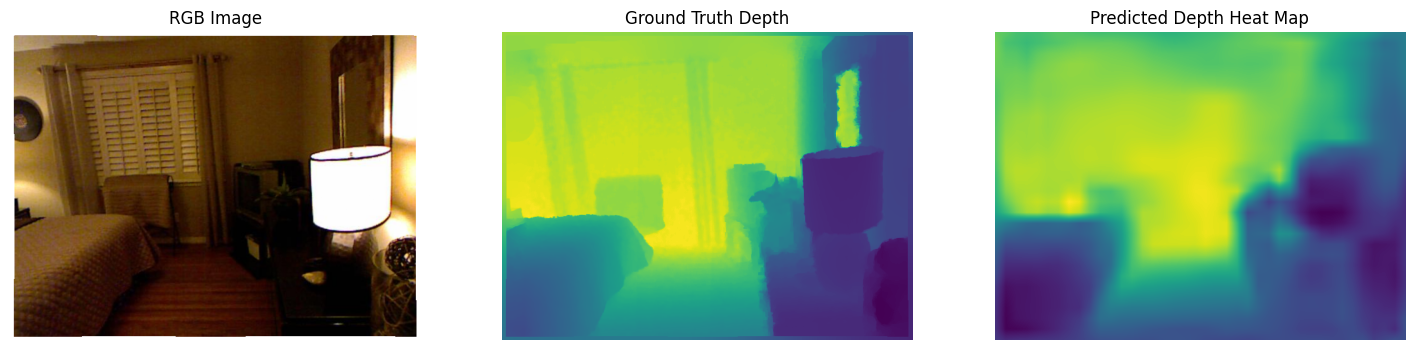

In [14]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = True)
test_and_visualize(model, test_loader, device)

Saved: output\rgb_images\rgb_0.png, output\predicted_depth\depth_0.png, and output\filtered_depth\filtered_depth_0.png


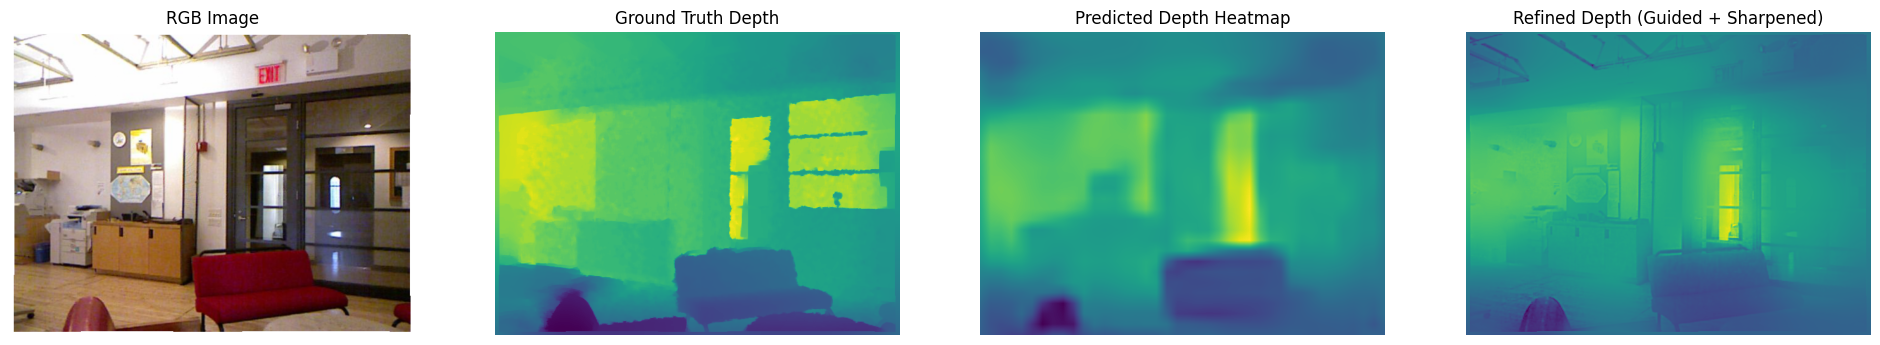

In [15]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage

def guided_filter(I, p, radius=64, eps=1e-3):
    """
    Perform guided filtering to refine the depth map.
    :param I: Guidance image (grayscale)
    :param p: Input image to be filtered (depth map)
    :param radius: Window radius
    :param eps: Regularization term
    :return: Filtered image
    """
    mean_I = scipy.ndimage.uniform_filter(I, radius)
    mean_p = scipy.ndimage.uniform_filter(p, radius)
    corr_I = scipy.ndimage.uniform_filter(I * I, radius)
    corr_Ip = scipy.ndimage.uniform_filter(I * p, radius)

    var_I = corr_I - mean_I * mean_I
    cov_Ip = corr_Ip - mean_I * mean_p

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = scipy.ndimage.uniform_filter(a, radius)
    mean_b = scipy.ndimage.uniform_filter(b, radius)

    q = mean_a * I + mean_b
    return q

def apply_guided_filter(rgb_img, pred_heatmap):
    # Convert RGB to grayscale
    guide_gray = np.mean(rgb_img, axis=2)  
    return guided_filter(guide_gray, pred_heatmap)

def enhance_sharpness(image, alpha=1.5, beta=-0.5):
    """
    Apply unsharp masking to enhance the sharpness of the image.
    :param image: Input grayscale image.
    :param alpha: Weight for the original image.
    :param beta: Weight for the blurred image.
    :return: Sharpened image.
    """
    blurred = cv2.GaussianBlur(image, (0, 0), 3)  # Gaussian Blur
    sharpened = cv2.addWeighted(image, alpha, blurred, beta, 0)
    return sharpened

def test_and_visualize(model, data_loader, device, save_dir="output"):
    model.eval()
    os.makedirs(f"{save_dir}/rgb_images", exist_ok=True)
    os.makedirs(f"{save_dir}/predicted_depth", exist_ok=True)
    os.makedirs(f"{save_dir}/filtered_depth", exist_ok=True)

    with torch.no_grad():
        for batch_idx, (rgb_tensor, depth_tensor) in enumerate(data_loader):
            rgb_tensor = rgb_tensor.to(device)
            depth_tensor = depth_tensor.to(device).float()
            
            pred_depth = model(rgb_tensor)  

            pred_depth = pred_depth.cpu().numpy()
            depth_tensor = depth_tensor.cpu().numpy()
            rgb_tensor = rgb_tensor.cpu().numpy()

            idx = 0
            rgb_img = np.transpose(rgb_tensor[idx], (1, 2, 0))  
            gt_depth = depth_tensor[idx, 0, :, :]
            pred_heatmap = pred_depth[idx, 0, :, :]
            
            pred_heatmap_norm = cv2.normalize(pred_heatmap, None, 0, 255, cv2.NORM_MINMAX)
            pred_heatmap_norm = np.uint8(pred_heatmap_norm)

            refined_depth = apply_guided_filter(rgb_img, pred_heatmap_norm)

            refined_depth_sharp = enhance_sharpness(refined_depth)

            rgb_save_path = os.path.join(save_dir, "rgb_images", f"rgb_{batch_idx}.png")
            depth_save_path = os.path.join(save_dir, "predicted_depth", f"depth_{batch_idx}.png")
            filtered_save_path = os.path.join(save_dir, "filtered_depth", f"filtered_depth_{batch_idx}.png")

            cv2.imwrite(rgb_save_path, cv2.cvtColor((rgb_img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
            cv2.imwrite(depth_save_path, pred_heatmap_norm)
            cv2.imwrite(filtered_save_path, refined_depth_sharp)

            print(f"Saved: {rgb_save_path}, {depth_save_path}, and {filtered_save_path}")

            plt.figure(figsize=(24, 6))

            plt.subplot(1, 4, 1)
            plt.imshow(rgb_img)
            plt.title("RGB Image")
            plt.axis("off")

            plt.subplot(1, 4, 2)
            plt.imshow(gt_depth, cmap='viridis')
            plt.title("Ground Truth Depth")
            plt.axis("off")

            plt.subplot(1, 4, 3)
            plt.imshow(pred_heatmap, cmap='viridis')
            plt.title("Predicted Depth Heatmap")
            plt.axis("off")

            plt.subplot(1, 4, 4)
            plt.imshow(refined_depth_sharp, cmap='viridis')
            plt.title("Refined Depth (Guided + Sharpened)")
            plt.axis("off")

            plt.show()
            break

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_and_visualize(model, test_loader, device)

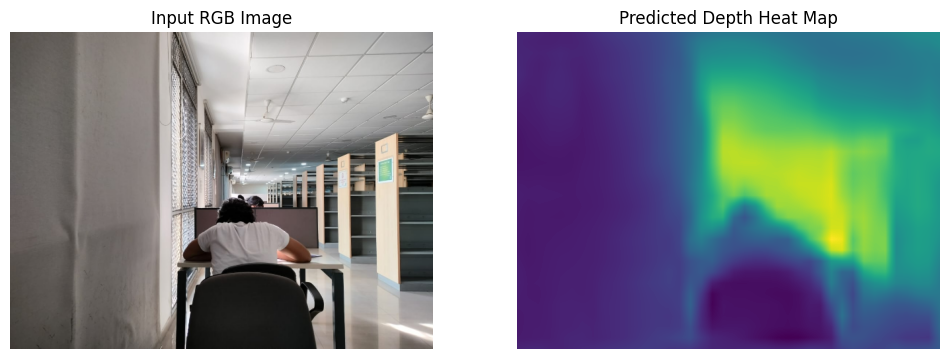

In [16]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

IMG_HEIGHT = 480
IMG_WIDTH = 640

def load_and_preprocess_image(image_path, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    """
    Loads an image from disk, resizes it, converts it to RGB,
    normalizes pixel values, and converts it to a torch tensor.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image from: {image_path}")
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    img = img.astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(np.transpose(img, (2, 0, 1)))
    img_tensor = img_tensor.unsqueeze(0)
    
    return img_tensor

test_image_path = "user_image_test_1.jpg"

new_img_tensor = load_and_preprocess_image(test_image_path).to(device)

model.eval()
with torch.no_grad():
    pred_depth = model(new_img_tensor)  
    
pred_depth = pred_depth.squeeze().cpu().numpy()  
pred_depth = cv2.resize(pred_depth, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LINEAR)

original_img = cv2.imread(test_image_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
original_img = cv2.resize(original_img, (IMG_WIDTH, IMG_HEIGHT))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Input RGB Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pred_depth, cmap='viridis')
plt.title("Predicted Depth Heat Map")
plt.axis("off")

plt.show()

Saved: output\rgb_images\user_image_test_1_rgb.png, output\predicted_depth\user_image_test_1_depth.png, and output\filtered_depth\user_image_test_1_filtered.png


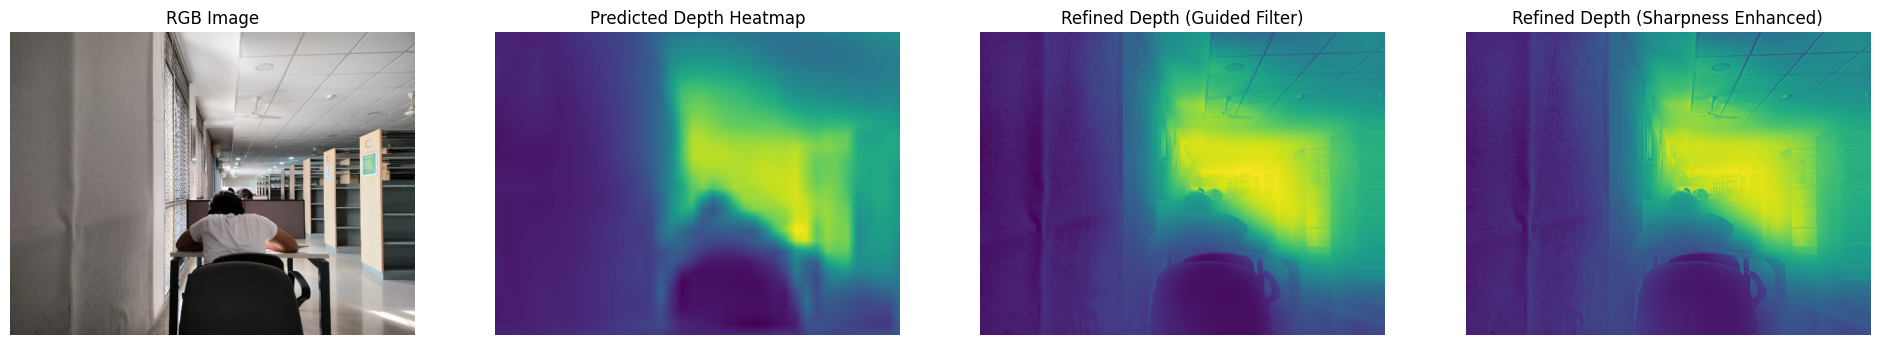

In [17]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy.ndimage
from torchvision import transforms

def guided_filter(I, p, radius=64, eps=1e-3):
    """
    Perform guided filtering to refine the depth map.
    :param I: Guidance image (grayscale)
    :param p: Input image to be filtered (depth map)
    :param radius: Window radius
    :param eps: Regularization term
    :return: Filtered image
    """
    mean_I = scipy.ndimage.uniform_filter(I, radius)
    mean_p = scipy.ndimage.uniform_filter(p, radius)
    corr_I = scipy.ndimage.uniform_filter(I * I, radius)
    corr_Ip = scipy.ndimage.uniform_filter(I * p, radius)

    var_I = corr_I - mean_I * mean_I
    cov_Ip = corr_Ip - mean_I * mean_p

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = scipy.ndimage.uniform_filter(a, radius)
    mean_b = scipy.ndimage.uniform_filter(b, radius)

    q = mean_a * I + mean_b
    return q

def apply_guided_filter(rgb_img, pred_heatmap):
    """
    Use the RGB image (converted to grayscale) as guidance to refine the depth map.
    """
    guide_gray = np.mean(rgb_img, axis=2)  # simple average to convert to grayscale
    return guided_filter(guide_gray, pred_heatmap)

def enhance_sharpness(image, alpha=1.5, beta=-0.5):
    """
    Enhance image sharpness using unsharp masking.
    :param image: Input image (grayscale)
    :param alpha: Weight for the original image.
    :param beta: Weight for the blurred image.
    :return: Sharpened image.
    """
    blurred = cv2.GaussianBlur(image, (0, 0), 3)
    sharpened = cv2.addWeighted(image, alpha, blurred, beta, 0)
    return sharpened

def load_and_preprocess_image(image_path, img_height=480, img_width=640):
    """
    Load an image from disk, resize, normalize, and convert to a torch tensor.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image from: {image_path}")
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    img = img.astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(np.transpose(img, (2, 0, 1)))  
    img_tensor = img_tensor.unsqueeze(0)  
    
    return img_tensor, img  


def test_image_path(model, device, image_path, save_dir="output", img_height=480, img_width=640):
    """
    Load an image from a given path, run the model to predict depth, and apply guided filtering
    and sharpness enhancement to refine the depth map.
    Saves and visualizes the results.
    """
    os.makedirs(os.path.join(save_dir, "rgb_images"), exist_ok=True)
    os.makedirs(os.path.join(save_dir, "predicted_depth"), exist_ok=True)
    os.makedirs(os.path.join(save_dir, "filtered_depth"), exist_ok=True)
    
    img_tensor, rgb_img = load_and_preprocess_image(image_path, img_height, img_width)
    img_tensor = img_tensor.to(device)
    
    model.eval()
    with torch.no_grad():
        pred_depth = model(img_tensor)
    
    pred_depth = torch.nn.functional.interpolate(pred_depth, size=(img_height, img_width), mode='bilinear', align_corners=True)
    
    pred_depth_np = pred_depth.squeeze().cpu().numpy()  
    
    pred_depth_norm = cv2.normalize(pred_depth_np, None, 0, 255, cv2.NORM_MINMAX)
    pred_depth_norm = np.uint8(pred_depth_norm)
    
    refined_depth = apply_guided_filter(rgb_img, pred_depth_norm)
    
    refined_depth_sharp = enhance_sharpness(refined_depth)
    
    base_filename = os.path.splitext(os.path.basename(image_path))[0]
    rgb_save_path = os.path.join(save_dir, "rgb_images", f"{base_filename}_rgb.png")
    depth_save_path = os.path.join(save_dir, "predicted_depth", f"{base_filename}_depth.png")
    filtered_save_path = os.path.join(save_dir, "filtered_depth", f"{base_filename}_filtered.png")
    
    cv2.imwrite(rgb_save_path, cv2.cvtColor((rgb_img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    cv2.imwrite(depth_save_path, pred_depth_norm)
    cv2.imwrite(filtered_save_path, refined_depth_sharp)
    
    print(f"Saved: {rgb_save_path}, {depth_save_path}, and {filtered_save_path}")
    
    plt.figure(figsize=(24, 6))
    
    plt.subplot(1, 4, 1)
    plt.imshow(rgb_img)
    plt.title("RGB Image")
    plt.axis("off")
    
    plt.subplot(1, 4, 2)
    plt.imshow(pred_depth_np, cmap='viridis')
    plt.title("Predicted Depth Heatmap")
    plt.axis("off")
    
    plt.subplot(1, 4, 3)
    plt.imshow(refined_depth, cmap='viridis')
    plt.title("Refined Depth (Guided Filter)")
    plt.axis("off")
    
    plt.subplot(1, 4, 4)
    plt.imshow(refined_depth_sharp, cmap='viridis')
    plt.title("Refined Depth (Sharpness Enhanced)")
    plt.axis("off")
    
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_image_file = "user_image_test_1.jpg" 
test_image_path(model, device, test_image_file, save_dir="output", img_height=480, img_width=640)

In [18]:
# import torch
# from torch.utils.data import DataLoader, Dataset
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F  
# from utils import get_data, DepthDataset, FlyDepth

# ROOT_DIR = "C:/Users/deshu/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/"
# IMG_HEIGHT = 480
# IMG_WIDTH = 640
# BATCH_SIZE = 4

# nyu_train_df, nyu_test_df = get_data(ROOT_DIR)

# train_dataset = DepthDataset(nyu_train_df, ROOT_DIR, IMG_HEIGHT, IMG_WIDTH)
# test_dataset = DepthDataset(nyu_test_df, ROOT_DIR, IMG_HEIGHT, IMG_WIDTH)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = FlyDepth(cnn_out_channels=64, gnn_hidden_dim=64, num_gnn_layers=2, fly_embed_dim=64).to(device)

# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# loss_fn = nn.MSELoss() 

# epochs = 10

# model.train()
# for epoch in range(epochs):
#     epoch_loss = 0.0
#     for rgb_tensor, depth_tensor in train_loader:
#         rgb_tensor = rgb_tensor.to(device)           
#         depth_tensor = depth_tensor.to(device).float() 
        
#         optimizer.zero_grad()
#         pred_depth = model(rgb_tensor)                 
#         loss = loss_fn(pred_depth, depth_tensor)
#         loss.backward()
#         optimizer.step()
        
#         epoch_loss += loss.item() * rgb_tensor.size(0)
    
#     avg_loss = epoch_loss / len(train_dataset)
#     print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")



# save_path = "cnn2gnn_flyprior.pth"
# torch.save({
#     'epoch': epochs,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'loss': avg_loss,
# }, save_path)
# print("Model saved at", save_path)

Saved: output\rgb_images\3_rgb.png, output\predicted_depth\3_depth.png, and output\filtered_depth\3_filtered.png


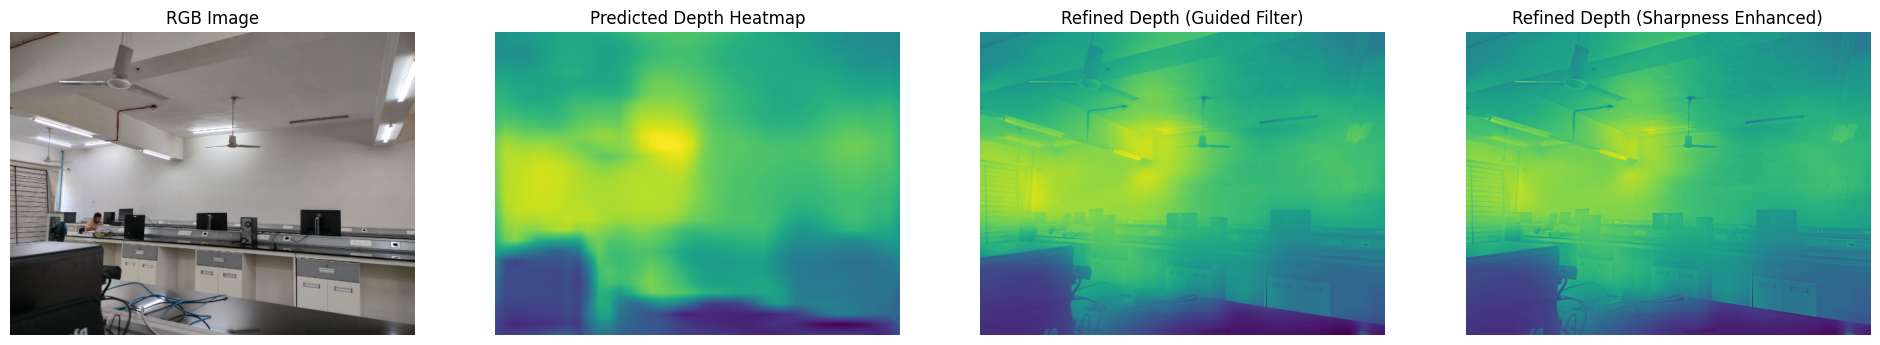

In [19]:
test_image_file_1 = "C:/Users/deshu/Desktop/FlyBrain/Testing_Images/3.jpg" 
test_image_path(model, device, test_image_file_1, save_dir="output")

Saved: output\rgb_images\2_rgb.png, output\predicted_depth\2_depth.png, and output\filtered_depth\2_filtered.png


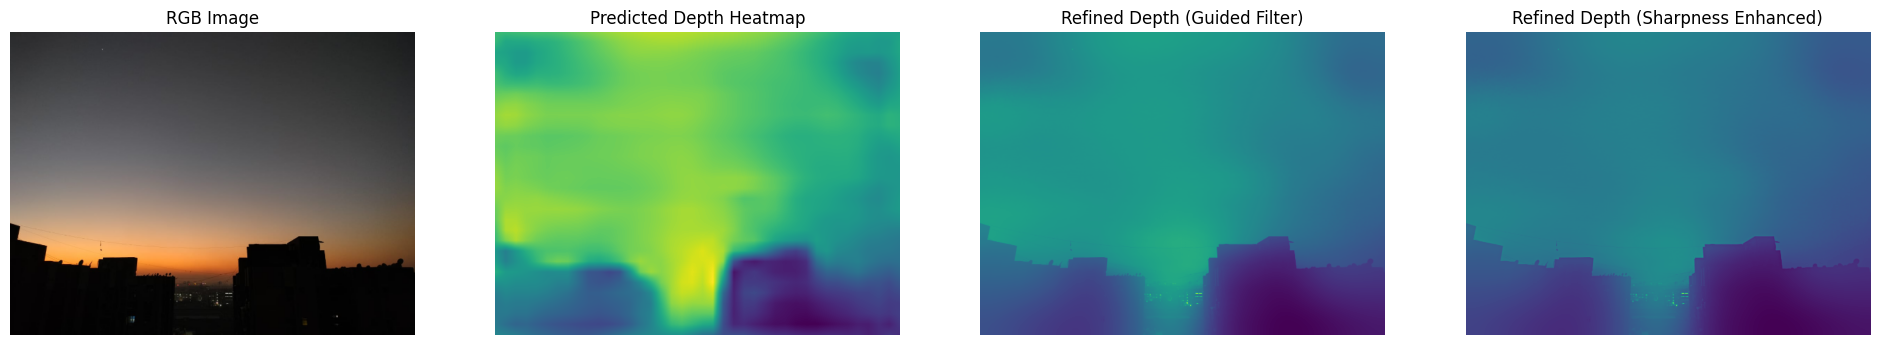

In [20]:
test_image_file_2 = "C:/Users/deshu/Desktop/FlyBrain/Testing_Images/2.jpg" 
test_image_path(model, device, test_image_file_2, save_dir="output")

In [21]:
neuron_features = pd.read_csv("filtered_neurons.csv")
edge_features = pd.read_csv("filtered_cells.csv")
all_neurons = pd.read_csv("filtered_neurons_all_features.csv")

In [22]:
neuron_features.head()

,Unnamed: 0,bodyId,type,pre,post,size
0,69718,2251225397,NaN,13,3,6796384
1,53681,1903362067,NaN,26,20,12958457
2,80812,2465106393,NaN,4,2,2684477
3,80160,2460357918,NaN,18,8,18561622
4,80704,2464472373,NaN,8,16,4746459


In [23]:
edge_features.head()

,bodyId_pre,bodyId_post,roi,weight
0,357250124,819725372,ICL(R),11
1,357250124,858812398,ICL(R),31
2,357250124,858812398,SCL(R),15
3,391289810,298935111,SLP(R),11
4,391289810,330268940,SLP(R),17


In [24]:
all_neurons.head()

,Unnamed: 0.1,Unnamed: 0,bodyId,instance,type,pre,post,downstream,upstream,mito,...,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,roiInfo,notes,inputRois,outputRois
0,0,69718,2251225397,NaN,NaN,13,3,76,3,2,...,Traced,True,Leaves,NaN,NaN,NaN,"{'OL(R)': {'pre': 13, 'post': 3, 'downstream':...",NaN,"['LO(R)', 'OL(R)']","['LO(R)', 'OL(R)']"
1,1,53681,1903362067,NaN,NaN,26,20,158,20,5,...,Traced,True,Leaves,NaN,NaN,NaN,"{'OL(R)': {'pre': 26, 'post': 20, 'downstream'...",NaN,"['LO(R)', 'OL(R)']","['LO(R)', 'OL(R)']"
2,2,80812,2465106393,NaN,NaN,4,2,16,2,2,...,Traced,True,Leaves,NaN,NaN,NaN,"{'OL(R)': {'pre': 4, 'post': 2, 'downstream': ...",NaN,"['LO(R)', 'OL(R)']","['LO(R)', 'OL(R)']"
3,3,80160,2460357918,NaN,NaN,18,8,145,8,4,...,Traced,True,Leaves,NaN,NaN,NaN,"{'OL(R)': {'pre': 18, 'post': 8, 'downstream':...",NaN,"['LO(R)', 'LOP(R)', 'OL(R)']","['LO(R)', 'LOP(R)', 'OL(R)']"
4,4,80704,2464472373,NaN,NaN,8,16,60,16,1,...,Traced,True,Leaves,NaN,NaN,NaN,"{'OL(R)': {'pre': 8, 'post': 16, 'downstream':...",NaN,"['LO(R)', 'OL(R)']","['LO(R)', 'OL(R)']"


In [25]:
def extract_xyz(location):
    if isinstance(location, str) and location.startswith("("):  
        x, y, z = location.strip("()").split(",")  
        return float(x), float(y), float(z)
    return 0.0, 0.0, 0.0  

In [26]:
import networkx as nx
from torch_geometric.utils import from_networkx

all_neurons[['x', 'y', 'z']] = all_neurons['somaLocation'].apply(lambda loc: pd.Series(extract_xyz(loc)))
all_neurons.drop(columns=['somaLocation'], inplace=True)
G = nx.DiGraph()  

for _, row in all_neurons.iterrows():
    G.add_node(row['bodyId'], 
               neuron_type=row['type'], 
               pre=row['pre'], 
               post=row['post'], 
               size=row['size'], 
               x=row['x'], 
               y=row['y'], 
               z=row['z'])

for _, row in edge_features.iterrows():
    G.add_edge(row['bodyId_pre'], row['bodyId_post'], 
               weight=row['weight'], 
               roi=row['roi'])

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

all_attrs = set()
for _, attr in G.nodes(data=True):
    all_attrs.update(attr.keys())  

for node in G.nodes:
    for attr in all_attrs:
        if attr not in G.nodes[node]: 
            G.nodes[node][attr] = 0  

data = from_networkx(G)
print(data) 

Graph has 11549 nodes and 14424 edges.
Data(x=[11549], edge_index=[2, 14424], y=[11549], neuron_type=[11549], pre=[11549], post=[11549], size=[11549], z=[11549], weight=[14424], roi=[14424])


In [27]:
# from node2vec import Node2Vec
# node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=1)
# model = node2vec.fit(window=10, min_count=1)

# embedding_dict = {}
# for node in G.nodes():
#     node_str = str(node)
#     try:
#         embedding_dict[node] = model.wv[node_str]
#     except KeyError:
#         print(f"Warning: Node {node_str} not present in embeddings. Assigning zero vector.")
#         embedding_dict[node] = np.zeros(64, dtype=np.float32)

# all_embeddings = np.array(list(embedding_dict.values()))
# avg_embedding = np.mean(all_embeddings, axis=0) 

# fly_prior_init = np.tile(avg_embedding, (600, 1))  
# fly_prior_init = torch.tensor(fly_prior_init, dtype=torch.float32)
# print(fly_prior_init)

In [28]:
# save_path="fly_prior.pt"
# torch.save(fly_prior_init, save_path)

In [30]:
save_path="fly_prior.pt"
fly_prior_init = torch.load(save_path)
print(fly_prior_init)

tensor([[ 0.1542, -0.0424,  0.2175,  ..., -0.2273, -0.0733,  0.0921],
        [ 0.1542, -0.0424,  0.2175,  ..., -0.2273, -0.0733,  0.0921],
        [ 0.1542, -0.0424,  0.2175,  ..., -0.2273, -0.0733,  0.0921],
        ...,
        [ 0.1542, -0.0424,  0.2175,  ..., -0.2273, -0.0733,  0.0921],
        [ 0.1542, -0.0424,  0.2175,  ..., -0.2273, -0.0733,  0.0921],
        [ 0.1542, -0.0424,  0.2175,  ..., -0.2273, -0.0733,  0.0921]])
